## RBNZ Bank Financial Strength Dashboard data app

The Financail Strength Dashboard is a great iniative of the RBNZ. It allows you to retrieve many data points from NZ banks on a quarterly basis.

The Reserve bank posts a spreadsheet on its web-site, which the scripts below then use for analysis. 

See this post for the grahps it produces: https://capitalissues.co/2018/11/27/updated-nz-capital-ratios/

Below are some code snippets to manage the RBNZ Bank Financial Strength Dashboard data.

### Where to find the data:

Go to: https://bankdashboard.rbnz.govt.nz/summary

Download the Excel file, via the link in the upper right corner of the site.

In [1]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
# To clean the series names
def fun(s):
    s = re.sub('\%', ' pct ', s)
    s = re.sub('\(.*\)', '', s)
    s = re.sub('[<>=\*\/]', '', s)
    s = re.sub('\s+', ' ', s)
    return(s)

In [3]:
# Generate a nice dataframe, select a month and year
def dash_data(fn, year, month):
    df = pd.read_excel(fn, sheet_name ='Data', skiprows=range(0,4), index_col=1)
    dfe= pd.read_excel(fn, sheet_name ='Series Definitions' , usecols = [1,2])[['Series Id', 'Series']]
    dfe['Series'] = dfe['Series'].apply(fun).str.strip()
    dfe['Code'], dfe['Series'] = dfe['Series'].str.split(' ', 1).str
    dfe['Code'] = dfe.Code.str.replace('.' , '')
    if month != 0:
        df = df.loc[(df['Series Id'].dt.month==month) & (df['Series Id'].dt.year==year)]
    df = df.rename(index=str, columns=dfe.set_index('Series Id')['Series'].to_dict())
    df = df.rename(index=str, columns={'Series Id': 'Date'})
    df.dropna(subset=['Total capital ratio'], inplace=True)  # ignore banks without TCR
    return(df)

In [14]:
# Get the data for September 2018, month = 9
# Set month to 0 for full panel
year, month = 2018, 9
fn = 'Bank-Financial-Strength-Dashboard-Data_June_2019.xlsx'
df = dash_data(fn, year, month)

In [15]:
dfe= pd.read_excel(fn, sheet_name ='Series Definitions' , usecols = [1,2])[['Series Id', 'Series']]
dfe.head()

,Series Id,Series
0,DBB.QIA10,A1. S&P Global
1,DBB.QIA20,A2. Fitch
2,DBB.QIA30,A3. Moody's
3,DBB.QIB10,C1. Total capital ratio
4,DBB.QIB12,C2. CET1 capital ratio


In [16]:
df.to_excel('dash_data.xls', index=False)

In [17]:
# Function to create a table of aggregated data, in LaTeX
def dash_table(df, varlist):
    dfw = df[varlist].fillna(0)
    som = dfw[varlist].sum() 
    rwa = som['Total RWAs']
    som_rwa = som/rwa
    som   = som.to_frame(name='summed').join(som_rwa.to_frame(name='ratios'))
    table = som.copy()
    table['Summed values'] = ['{:,.0f}'.format(x) for x in table['summed']]
    table['Ratios'] = ['{:,.2f}'.format(x) for x in table['ratios']*100]
    print(table[['Summed values', 'Ratios']].to_latex())
    return(som, table)

In [18]:
# Create a table of aggregated data, in Latex
varlist = ['Equity', 'CET1 capital', 'CET1 deductions','Net CET1', 'Additional Tier 1 instruments', 'Total Tier 1 capital', 'Tier 2 instruments', 'Total capital', 'Total RWAs']
som, table = dash_table(df, varlist)

\begin{tabular}{lll}
\toprule
{} & Summed values &  Ratios \\
\midrule
Equity                        &        41,370 &   13.97 \\
CET1 capital                  &        39,484 &   13.34 \\
CET1 deductions               &         5,871 &    1.98 \\
Net CET1                      &        33,614 &   11.35 \\
Additional Tier 1 instruments &         6,326 &    2.14 \\
Total Tier 1 capital          &        39,940 &   13.49 \\
Tier 2 instruments            &         3,301 &    1.11 \\
Total capital                 &        43,241 &   14.60 \\
Total RWAs                    &       296,092 &  100.00 \\
\bottomrule
\end{tabular}



In [19]:
# Function to single out the big banks
# thresh -> minimum RWA in $m
def bigbanks(df, thresh):
    dfb = df[['Net CET1', 'Total RWAs']].copy()
    dfb["CET1_ratio"] = dfb['Net CET1'].div(dfb['Total RWAs'])*100
    dfb["Size"] = np.log(dfb['Total RWAs'])
    dfb = dfb.loc[dfb['Total RWAs']>thresh]
    return(dfb)

In [20]:
dfb = bigbanks(df, 50000)
dfb.head()

,Net CET1,Total RWAs,CET1_ratio,Size
Institution,,,,
ANZ,9081.5,82147.0,11.055182,11.316266
ASB,6052.8,56608.8,10.692331,10.943920
BNZ,6810.1,64491.8,10.559637,11.074293
Westpac,6289.9,53820.0,11.686919,10.893400


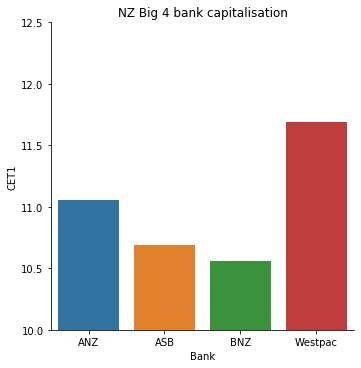

In [21]:
def graph_big_banks(dfb):
    #seq_col_brew = sns.color_palette("Blues_r", 4)
    #sns.set_palette(seq_col_brew)
    ax  = sns.catplot(x = "Institution", y = "CET1_ratio", kind="bar", data = dfb.reset_index())
    nofbanks = len(dfb)
    plt.ylim(10, 12.5)
    plt.title('NZ Big ' + str(nofbanks)+ ' bank capitalisation')
    plt.xlabel('Bank')
    plt.ylabel('CET1')
    plt.show()
graph_big_banks(dfb)

In [22]:
# Function to select all banks
def all_banks(df):
    df = df[['Net CET1', 'Total RWAs']].copy()
    df["CET1_ratio"] = df['Net CET1'].div(df['Total RWAs'])*100
    df["Size"] = np.log(df['Total RWAs'])
    df = df.loc[df.CET1_ratio<30]
    return(df)

In [23]:
# Select all banks for graphs
data = all_banks(df)

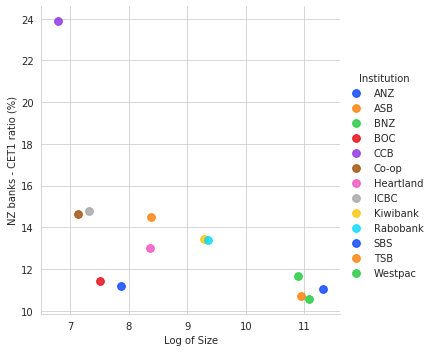

In [24]:
# Plot the banks' capitalisation
def graph_bank_cap(data):
    sns.set_style("whitegrid")
    ax = sns.lmplot(data=data.reset_index(), x="Size", y="CET1_ratio", hue='Institution', palette = 'bright', scatter_kws={"s": 60}, fit_reg=False) #
    ax.set(xlabel='Log of Size', ylabel='NZ banks - CET1 ratio (%)')
    plt.show()
graph_bank_cap(data)

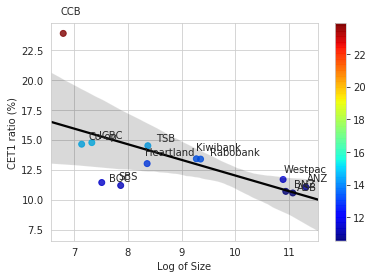

In [25]:
# Another plot of the banks' capitalisation
def graph_size_cap(data):
    offset = 1
    sns.set_style("whitegrid")
    ax = plt.scatter(data["Size"],data["CET1_ratio"], alpha = .8, c = data["CET1_ratio"], cmap = 'jet')
    for label, x, y in zip(data.reset_index()['Institution'], data["Size"], data["CET1_ratio"]):
        plt.annotate(label, xy = (x, y), xytext = (x -10*(offset & 1), y -10 + 5*(offset & 1) ), textcoords = 'offset points')
        offset +=1
    cbar = plt.colorbar()
    sns.regplot(data["Size"],data["CET1_ratio"], data=data, scatter=False, color=".01")
    plt.xlabel('Log of Size')
    plt.ylabel('CET1 ratio (%)')
    plt.show()
graph_size_cap(data)